## Copies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#random.seed(24)

n=1000

sim = 10000

a = 1
b = 1
p=0.9

In [3]:
class dataset:
    def __init__(self,n,p,df):
        #Number of observations
        self.n = n
        #MCAR Bernoulli prob.
        self.p = p
        #data set 
        self.df = df 
        
    #Ishigami function
        #np.random.seed(24)   
    
    def ishigami(self):
        return lambda a, b:  np.sin(self.df['X1']) + a * np.sin(self.df['X2'])**2 + b * (self.df['X3'])**4 * np.sin(self.df['X1']) + np.random.normal(0, 0.01, self.n)
    
    def toyreg(self):
        return lambda b1,b2: b1*self.df['X1'] + b2*self.df['X2'] + np.random.normal(0, 0.1, self.n)
    
    #H-Sample with target from Ishigami function
    
    def h_df(self,a,b):
        self.df['Y'] = self.ishigami()(a,b)
        return self.df['Y']
    
    def picked(self,request,a,b):
        #request are the variables to be randomized, e.g. ['X2','X3']
        newdf = self.df.copy()
        values  = [list(pd.Series(np.random.uniform(0,1,self.n)))]*len(request)
        dictionary = dict(zip(request, values))
        for col, new_values in dictionary.items():
            newdf = newdf.assign(**{col: new_values})
        return newdf
    
    def mcar(self,a,b):
        #self.df['Y'] = self.ishigami()(a,b)
        mask = np.random.binomial(size=(self.n,3), n=1, p= self.p) == 1
        mask = np.reshape(mask,(self.n,3))
        #print(mask)
        df1 = self.df.where(mask,np.nan)
        #print(df1)
        return df1.dropna()
    
    def mar(self,cond1,cond2,var1='X1',var2='X3'):
        cond_x = np.where((self.df[var1] <0.5) , 0, 1) # & or (self.df['X3'] <0.1)
        omega = (np.random.binomial(size=(self.n,1), n=1, p= p) == 1)  #omega.shape 
        omega = np.reshape(omega,(self.n,))
        condition = (omega & (cond_x  ==1)) | (cond_x  ==0)
        self.df[var2] = np.where(condition,np.array(self.df[var2]),np.nan)
        return self.df.dropna()
    
    def mnar(self,cond1,cond2,var):
        cond_x = np.where((self.df[var] <0.5) , 1, 0) # & or (self.df['X3'] <0.1)
        omega = (np.random.binomial(size=(self.n,1), n=1, p= p) == 1)  #omega.shape 
        omega = np.reshape(omega,(self.n,))
        condition = (omega & (cond_x  ==1)) & (cond_x  ==0)
        self.df[var] = np.where(condition,np.array(self.df[var]),np.nan)
        return self.df.dropna()
    


In [4]:
df    = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])

In [5]:
class sobol:
    def __init__(self,n,p,df):
        #Number of observations
        self.n = n
        #MCAR Bernoulli prob.
        self.p = p
        #data set 
        self.df = df 
    
    def foe(self,request,sim,a,b):
        sobol_list = []
        for x in range(sim):
            newdf   = dataset(self.n,self.p,self.df).picked(request,a,b)
            self.df['Y'] = dataset(self.n,self.p,self.df).h_df(a,b)
            newdf['Y']   = dataset(self.n,self.p,newdf).h_df(a,b)
            sobol_list.append((np.cov(self.df.Y,newdf.Y)/np.var(self.df.Y))[0][1])
        return sobol_list
        

In [6]:
def sobol(request,sim):
    sobol_list = []
    for x in range(sim):
        df      = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
        newdf   = dataset(n,p,df).picked(request,a,b)
        df['Y']    = dataset(n,p,df).h_df(a,b)
        newdf['Y'] = dataset(n,p,newdf).h_df(a,b)
        sobol_list.append((np.cov(df.Y,newdf.Y)/np.var(df.Y))[0][1])
    return sobol_list

Text(0.5, 1.0, '')

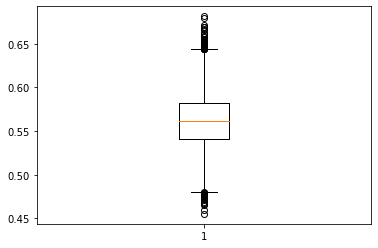

In [7]:
#singletons H-Sample
sobol_X1 = sobol(['X2','X3'],sim)
sobol_X2 = sobol(['X1','X3'],sim)
sobol_X3 = sobol(['X1','X3'],sim)
plt.boxplot(sobol_X1)
plt.title('')

[Text(1, 0, 'X1'), Text(2, 0, 'X2'), Text(3, 0, 'X3')]

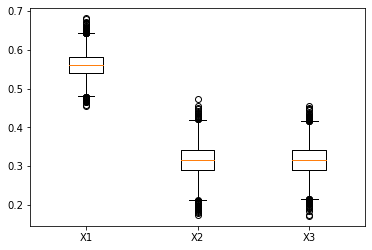

In [8]:
singletons = dict(zip(['X1','X2','X3'],[sobol_X1,sobol_X2,sobol_X3]))

fig, ax = plt.subplots()
ax.boxplot(singletons.values())
ax.set_xticklabels(singletons.keys())

In [9]:
df_singletons = pd.DataFrame(singletons)
#sns.violinplot(data=df_singletons)

In [10]:
def sobol_mis(request,sim):
    sobol_list = []
    for x in range(sim):
        df      = pd.DataFrame(np.random.uniform(0,1,size=(n, 3)),columns=['X1','X2','X3'])
        cc = dataset(n,p,df).mcar(a,b)
        cc['Y'] = dataset(len(cc),p,cc).h_df(a,b)
        newcc   = dataset(len(cc),p,cc).picked(request,a,b)
        newcc['Y'] = dataset(len(cc),p,newcc).h_df(a,b)
        sobol_list.append((np.cov(cc.Y,newcc.Y)/np.var(cc.Y))[0][1])
    return sobol_list

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb8643a5a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb8643b3190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb8643a5730>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb8643b3850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb8643b3bb0>],
 'means': []}

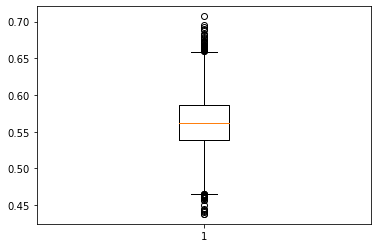

In [11]:
#singletons test 
sobol_X1_mis = sobol_mis(['X2','X3'],sim)
sobol_X2_mis = sobol_mis(['X1','X3'],sim)
sobol_X3_mis = sobol_mis(['X1','X3'],sim)
plt.boxplot(sobol_X1_mis)

In [12]:
singletons_mis = dict(zip(['X1','X2','X3'],[sobol_X1_mis,sobol_X2_mis,sobol_X3_mis]))

[Text(1, 0, 'X1'), Text(2, 0, 'X2'), Text(3, 0, 'X3')]

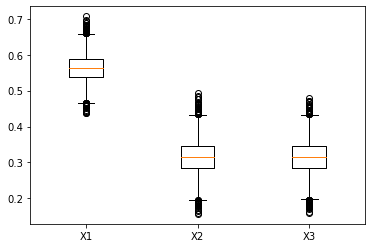

In [13]:
fig, ax = plt.subplots()
ax.boxplot(singletons_mis.values())

ax.set_xticklabels(singletons_mis.keys())

<AxesSubplot:>

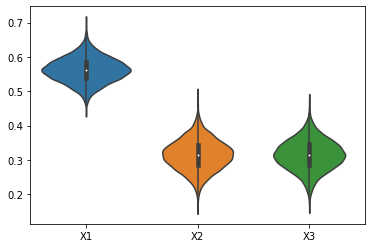

In [14]:
df_singletons_mis = pd.DataFrame(singletons_mis)

sns.violinplot(data=df_singletons_mis)

In [15]:
df_singletons_mis['sample'] = 'cc'
df_singletons['sample'] = 'complete'

cdf = pd.concat([df_singletons, df_singletons_mis],axis=0)

dd = pd.melt(cdf, id_vars= ['sample'],value_vars=['X1','X2','X3'],var_name='Variable')

dd = dd.rename(columns={'value':'Sobol index'})

#dd

[(0.0, 1.0)]

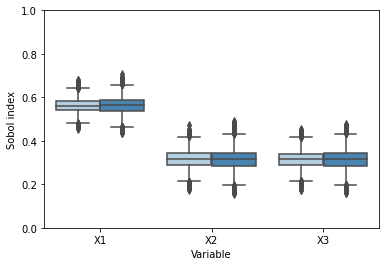

In [16]:
ax =sns.boxplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")
ax.legend_.remove()
ax.set(ylim=(0, 1))


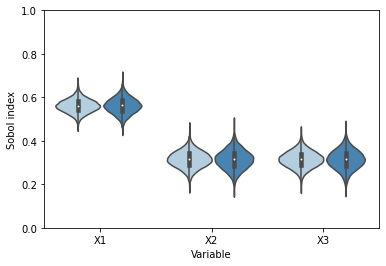

In [17]:
ax = sns.violinplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")

ax.legend_.remove()

fig = ax.get_figure()
ax.set(ylim=(0, 1))
fig.savefig('violin_cc_true.pdf',transparent=True,bbox_inches='tight')

In [18]:
def sobolplot(n,sim,p):
    sobol_X1 = sobol(['X2','X3'],sim)
    sobol_X2 = sobol(['X1','X3'],sim)
    sobol_X3 = sobol(['X1','X3'],sim)
    singletons = dict(zip(['X1','X2','X3'],[sobol_X1,sobol_X2,sobol_X3]))
    df_singletons = pd.DataFrame(singletons)
    df_singletons['sample'] = 'complete'
    #Missings
    sobol_X1_mis = sobol_mis(['X2','X3'],sim)
    sobol_X2_mis = sobol_mis(['X1','X3'],sim)
    sobol_X3_mis = sobol_mis(['X1','X3'],sim)
    singletons_mis = dict(zip(['X1','X2','X3'],[sobol_X1_mis,sobol_X2_mis,sobol_X3_mis]))
    df_singletons_mis = pd.DataFrame(singletons_mis)
    df_singletons_mis['sample'] = 'cc'
    #Merge
    cdf = pd.concat([df_singletons, df_singletons_mis],axis=0)  
    dd = pd.melt(cdf, id_vars= ['sample'],value_vars=['X1','X2','X3'],var_name='Variable')
    dd = dd.rename(columns={'value':'Sobol index'})
    dd.to_csv('Sobol singleton for p='+str(p)+'.csv')  
    ax = sns.boxplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues") #,showfliers=False
    #ax = sns.violinplot(x='Variable',y='Sobol index',data=dd,hue='sample',palette="Blues")
    ax.legend_.remove()
    ax.set(ylim=(0.15, 0.7))
    fig = ax.get_figure()
    plt.close(fig)
    fig.savefig('images/boxplot/cc/boxplot_cc_true for p='+str(p)+'.pdf',transparent=True,bbox_inches='tight')
    return fig
    

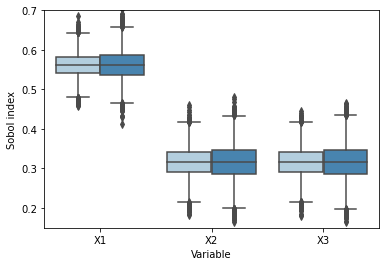

In [19]:
sobolplot(n,sim,0.9)

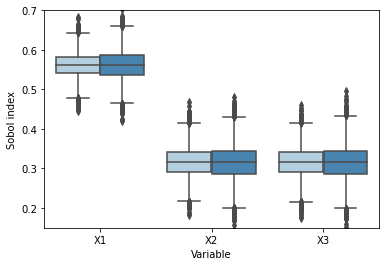

In [20]:
sobolplot(n,sim,0.75)

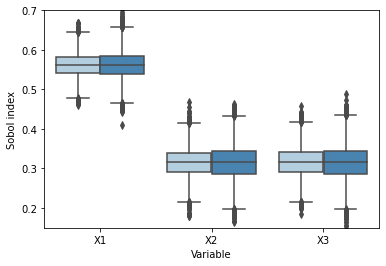

In [21]:
sobolplot(n,sim,0.4)